# Network Analysis with NetworkX
*For the third course in a CDCS Python Library Series taught November-December 2020 by Lucy Havens*

Use this notebook to practice analyzing network data in Python with [NetworkX](https://networkx.org/documentation/stable/install.html).

We follow The Programming Historian's tutorial on [Exploring and Analysing Network Data with Python](https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python#fn:pipinstall) to create an undirected network from CSV data.

***

## 1. Preparation
### Import libraries
The following libraries must be installed on the server where you are running this Notebook (if you're using MyBinder, this is done automatically during the MyBinder setup).

In [59]:
import re
import string
import pandas as pd
import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt
from networkx import Graph

### Review the Data
To take a look at the data we'll be working with, we'll load data files provided in the [tutorial](https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python#fn:pipinstall).  Download the data files and save them inside the same folder as this Notebook (if you're using MyBinder, this has already been done for you).

In [2]:
# Read the CSV data
edges_df = pd.read_csv('quakers_edgelist.csv')

# Display the first five rows of the data in a DataFrame 
# (a DataFrame is a sort of table provided in the Pandas library)
edges_df.head()

,Source,Target
0,George Keith,Robert Barclay
1,George Keith,Benjamin Furly
2,George Keith,Anne Conway Viscountess Conway and Killultagh
3,George Keith,Franciscus Mercurius van Helmont
4,George Keith,William Penn


In [3]:
# Read the CSV data
nodes_df = pd.read_csv('quakers_nodelist.csv')

# Display the first five rows of the data in a DataFrame 
# (a DataFrame is a sort of table provided in the Pandas library)
nodes_df.head()

,Name,Historical Significance,Gender,Birthdate,Deathdate,ID
0,Joseph Wyeth,religious writer,male,1663,1731,10013191
1,Alexander Skene of Newtyle,local politician and author,male,1621,1694,10011149
2,James Logan,colonial official and scholar,male,1674,1751,10007567
3,Dorcas Erbery,Quaker preacher,female,1656,1659,10003983
4,Lilias Skene,Quaker preacher and poet,male,1626,1697,10011152


In [14]:
# To determine the size of our DataFrames,
# print their number of rows and columns
print("Edges Data")
print("  Rows:", edges_df.shape[0], "| Columns:", edges_df.shape[1])
print("Nodes Data")
print("  Rows:", nodes_df.shape[0], "| Columns:", nodes_df.shape[1])

Edges Data
  Rows: 174 | Columns: 2
Nodes Data
  Rows: 119 | Columns: 6


Let's gather some summary information about the data.

In [48]:
# Display the unique values in the "Historical Significance" column
hist_sign_values = nodes_df['Historical Significance'].unique()
print("Total unique values:",len(hist_sign_values))
print(hist_sign_values)

Total unique values: 66
['religious writer' 'local politician and author'
 'colonial official and scholar' 'Quaker preacher'
 'Quaker preacher and poet' 'Quaker preacher and writer' 'Quaker activist'
 'Quaker minister and schoolmaster' 'printer'
 'philosophical writer and playwright'
 'political economist and cloth merchant'
 ' a founder of the Religious Society of Friends (Quakers)'
 'Quaker minister' 'Quaker missionary' 'Quaker activist and physician'
 'Quaker leader' 'Quaker activist and writer'
 'merchant and pioneer settler in America' 'banker and lobbyist'
 'politician' 'Quaker patron and merchant' 'religious controversialist'
 'Quaker leader and writer' 'Quaker administrator'
 'historian of Quakerism' 'Quaker minister and preacher'
 'merchant and religious writer' 'apothecary'
 'Quaker adherent and sectary' 'Quaker bibliographer and writer'
 'religious writer and schoolmaster' 'Quaker minister and botanist'
 'merchant and official in America' 'Quaker minister and writer'
 'relig

In [20]:
# Determine the earliest and latest birthdates and deathdates
print("Earliest birth:", nodes_df['Birthdate'].min())
print("Latest birth:", nodes_df['Birthdate'].max())
print("Earliest death:", nodes_df['Deathdate'].min())
print("Latest death:", nodes_df['Deathdate'].max())

Earliest birth: 1551
Latest birth: 1699
Earliest death: 1656
Latest death: 1777


In [23]:
# Determine how many males and females are in the data
print("Number of males:",nodes_df[nodes_df["Gender"] == "male"].shape[0])
print("Number of females:",nodes_df[nodes_df["Gender"] == "female"].shape[0])

Number of males: 97
Number of females: 22


Now, we'll create a Python list of node names and of edges.  There are  two ways to do this:
#### Option A
This option doesn't use Pandas (the library we loaded at the top of the Notebook and gave the alias `pd`).

In [25]:
import csv
import operator as itemgetter

# Open the nodes file
with open('quakers_nodelist.csv', 'r') as nodecsv:
    # Read the csv
    nodereader = csv.reader(nodecsv)
    # Retrieve the data (using Python list comprhension and list slicing to remove the header row, see footnote 3)
    nodes = [n for n in nodereader][1:]
# Get a list of only the node names
node_names = [n[0] for n in nodes] 

# Open the edges file
with open('quakers_edgelist.csv', 'r') as edgecsv:
    # Read the csv
    edgereader = csv.reader(edgecsv)
     # Retrieve the edges data
    edges = [tuple(e) for e in edgereader][1:]

In [29]:
print("Some Node Names:")
print(node_names[:20])
print("\nSome Edges:")
print(edges[:20])

Some Node Names:
['Joseph Wyeth', 'Alexander Skene of Newtyle', 'James Logan', 'Dorcas Erbery', 'Lilias Skene', 'William Mucklow', 'Thomas Salthouse', 'William Dewsbury', 'John Audland', 'Richard Claridge', 'William Bradford', 'Fettiplace Bellers', 'John Bellers', 'Isabel Yeamans', 'George Fox the younger', 'George Fox', 'John Stubbs', 'Anne Camm', 'John Camm', 'Thomas Camm']

Some Edges:
[('George Keith', 'Robert Barclay'), ('George Keith', 'Benjamin Furly'), ('George Keith', 'Anne Conway Viscountess Conway and Killultagh'), ('George Keith', 'Franciscus Mercurius van Helmont'), ('George Keith', 'William Penn'), ('George Keith', 'George Fox'), ('George Keith', 'George Whitehead'), ('George Keith', 'William Bradford'), ('James Parnel', 'Benjamin Furly'), ('James Parnel', 'Stephen Crisp'), ('Peter Collinson', 'John Bartram'), ('Peter Collinson', 'James Logan'), ('Joseph Wyeth', 'Thomas Ellwood'), ('Alexander Skene of Newtyle', 'Lilias Skene'), ('Dorcas Erbery', 'James Nayler'), ('William

#### Option B
This option uses Pandas.

In [44]:
node_names = list(nodes_df["Name"])
edges = list(zip(list(edges_df["Source"]), list(edges_df["Target"])))

In [46]:
print("Some Node Names:")
print(node_names[:20])
print("\nSome Edges:")
print(edges[:20])

Some Node Names:
['Joseph Wyeth', 'Alexander Skene of Newtyle', 'James Logan', 'Dorcas Erbery', 'Lilias Skene', 'William Mucklow', 'Thomas Salthouse', 'William Dewsbury', 'John Audland', 'Richard Claridge', 'William Bradford', 'Fettiplace Bellers', 'John Bellers', 'Isabel Yeamans', 'George Fox the younger', 'George Fox', 'John Stubbs', 'Anne Camm', 'John Camm', 'Thomas Camm']

Some Edges:
[('George Keith', 'Robert Barclay'), ('George Keith', 'Benjamin Furly'), ('George Keith', 'Anne Conway Viscountess Conway and Killultagh'), ('George Keith', 'Franciscus Mercurius van Helmont'), ('George Keith', 'William Penn'), ('George Keith', 'George Fox'), ('George Keith', 'George Whitehead'), ('George Keith', 'William Bradford'), ('James Parnel', 'Benjamin Furly'), ('James Parnel', 'Stephen Crisp'), ('Peter Collinson', 'John Bartram'), ('Peter Collinson', 'James Logan'), ('Joseph Wyeth', 'Thomas Ellwood'), ('Alexander Skene of Newtyle', 'Lilias Skene'), ('Dorcas Erbery', 'James Nayler'), ('William

## 2. Put the Data in a Graph
Let's start using NetworkX!

In [61]:
# Initialize a graph (a.k.a. network)
G = nx.Graph()
# Add nodes to the graph
G.add_nodes_from(node_names)
# Connect those nodes with edges
G.add_edges_from(edges)
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 119
Number of edges: 174
Average degree:   2.9244


*Note: The `degree` of the node is the number of connections that node has to other nodes, or the number of edges that are tied to that node.  `Average degree` thus means the average number of edges per node.*

In [62]:
# Create lists of values from each column of the nodes DataFrame
hs_list = list(nodes_df["Historical Significance"])
g_list = list(nodes_df["Gender"])
b_list = list(nodes_df["Birthdate"])
d_list = list(nodes_df["Deathdate"])
i_list = list(nodes_df["ID"])

In [63]:
# Create dictionaries for each column, or attribute type, in the nodes DataFrame,
# where the key is a node name and the value is an attribute
hist_sig = dict(zip(node_names, hs_list))
gender = dict(zip(node_names, g_list))
birth = dict(zip(node_names, b_list))
death = dict(zip(node_names, d_list))
ids = dict(zip(node_names, i_list))
#print(hist_sig)

In [64]:
# Add the attributes to the graph
nx.set_node_attributes(G, hist_sig, 'historical_significance')
nx.set_node_attributes(G, gender, 'gender')
nx.set_node_attributes(G, birth, 'birth_year')
nx.set_node_attributes(G, death, 'death_year')
nx.set_node_attributes(G, ids, 'id')

Let's try printing an attribute for each node in our graph to make sure it's been created as expected.

In [65]:
# Loop through all the nodes in the graph,
# where n represents the name of a node
for n in G.nodes():
    print(n, G.nodes[n]['birth_year'])

Joseph Wyeth 1663
Alexander Skene of Newtyle 1621
James Logan 1674
Dorcas Erbery 1656
Lilias Skene 1626
William Mucklow 1630
Thomas Salthouse 1630
William Dewsbury 1621
John Audland 1630
Richard Claridge 1649
William Bradford 1663
Fettiplace Bellers 1687
John Bellers 1654
Isabel Yeamans 1637
George Fox the younger 1551
George Fox 1624
John Stubbs 1618
Anne Camm 1627
John Camm 1605
Thomas Camm 1640
Katharine Evans 1618
Lydia Lancaster 1683
Samuel Clarridge 1631
Thomas Lower 1633
Gervase Benson 1569
Stephen Crisp 1628
James Claypoole 1634
Thomas Holme 1626
John Freame 1665
John Swinton 1620
William Mead 1627
Henry Pickworth 1673
John Crook 1616
Gilbert Latey 1626
Ellis Hookes 1635
Joseph Besse 1683
James Nayler 1618
Elizabeth Hooten 1562
George Whitehead 1637
John Whitehead 1630
William Crouch 1628
Benjamin Furly 1636
Silvanus Bevan 1691
Robert Rich 1607
John Whiting 1656
Christopher Taylor 1614
Thomas Lawson 1630
Richard Farnworth 1630
William Coddington 1601
Thomas Taylor 1617
Richard 

## 4. Print the Graph

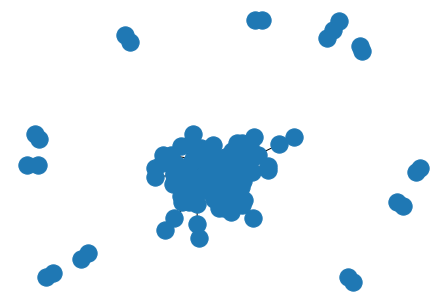

In [66]:
nx.draw(G)

## 5. Analyze the Graph
Following along from the section of the [tutorial](https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python#fn:pipinstall) called "Metrics available in NetworkX," analyze the graph yourself in this section!